# Proyecto Final de la asignatura de Visión Artificial y Reconocimiento de Patrones
Cuaderno correspondiente al proyecto final de la asignatura de Visión Artificial y Reconocimiento de Patrones con el objetivo de mostrar las distintas técnicas aprendidas a lo largo del curso. El problema tratará de una clasificación de animales repartidas en 10 clases desbalanceadas, lo que modificará nuestra forma de evaluación del modelo. Dicho proyecto será realizado en Kaggle dado que nos da la oportunidad de ejecutarlo en un entorno óptimo para el problema.

**Proyecto realizado por:**

   * ### **Domingo José Caballero Navarro**
   
   * ### **Rubén Castillo Carrasco**
   
**Proyecto supervisado por:**

   * ### **José Miguel Puerta Callejón**
   
   * ### **Luis González Naharro**
   
**Asignatura:** 

   * ### **Visión Artificial y Reconocimiento de Patrones (Universidad de Castilla-La Mancha)**

# Clasificación de animales repartidos en 10 clases desbalanceadas
El problema que se nos presenta es el de clasificar distintas imágenes entre 10 tipos de clases. Dichas clases se encuentran desbalanceadas, algo muy importante a tener en cuenta a la hora de la validación. Lo que se realizará en este cuaderno lo podemos ver reflejado a continuación:

### **Índice:**
1. [Introducción al problema](#introduccion)
2. [Análisis exploratorio de los datos](#analisis)
3. [Preprocesamiento de los datos](#preprocesamiento)
4. [Diseño de diferentes modelos](#creacion)
5. [Análisis de los resultados obtenidos](#resultados)
6. [Detalles del modelo final: Ensemble](#validacion)
7. [Conclusión](#conclusion)

# 1. Introducción<a name="introduccion"></a>
Par la realización de este proyecto utilizaremos las librerías principales para el tratamiento de imágenes y redes neuronales. Por lo tanto, empezaremos importanto `numpy`, `pandas`, `os`, `cv2`, `keras` y `glob`.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
import tensorflow as tf

Además, activaremos la GPU que nos ofrece Kaggle para poder acelerar el entrenamiento de nuestros modelos mejorando así el tiempo de ejecución.

In [2]:
device_type = "GPU"  # The device type
devices = tf.config.list_physical_devices(device_type)

if not devices:
    # Raise an informative message when there are no devices in the host runtime
    raise RuntimeError(f"No {device_type} devices are used in the host.")

2023-01-11 16:01:33.933612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 16:01:34.086470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 16:01:34.087369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 2. Análisis exploratorio de los datos<a name="analisis"></a>
El primer paso que tenemos que hacer a la hora de inicar un proyecto es cargar y dividir nuestro conjunto de datos en entrenamiento, validación y test. Obteniendo así los conjuntos que utilizaremos para validar nuestros modelos y para entrenarlos. 

Posteriormente a la división empezaremos con el análisis exploratorio de datos en el que observaremos como esta formado nuestro conjunto de **entrenamiento**, es importante destacar que se realiza sobre el entrenamiento dado que si observaramos el test estaríamos causando una fuga de datos. Con esto queremos expresar que si nos fijamos en el test para crear nuestro modelo o nuestro preprocesamiento estaríamos alterando el resultado de validación, haciendo que nuestro modelo en producción se vea perjudicado.

Para dividir nuestro conjunto de datos utilizaremos `split-folders`.

In [3]:
! pip install split-folders

Una vez instalado pasaremos a importar las librerías necesarias para el apartado de carga de los datos y para el análisis exploratorio de datos.

In [4]:
import splitfolders
import matplotlib.pyplot as plt
import PIL
import pathlib
import plotly.graph_objects as go
import itertools
import plotly.express as px

Una vez tenemos cargadas las librerías necesarías procedemos a cargar los datos, para ello lo primero que hacemos es almacenar el camino dónde se encuentran los datos.

In [5]:
path = "../input/animals10/raw-img"
path = pathlib.Path(path)

A continuación, teniendo el camino dónde se encuentran el conjunto de datos los cargamos en images.

In [6]:
images = glob.glob('../input/animals10/raw-img/*/*.jpeg')
print("El número de imágenes es: ", len(images))
images = pd.Series(images)

El número de imágenes es:  24209


Una vez tenemos las imágenes cargadas nos encargamos de organizar correctamente los datos.

In [7]:
df = pd.DataFrame()

df['FileName'] = images.map(lambda image_name :image_name.split("H")[-1])

df['ClassId'] = images.map(lambda image_name :image_name.split("/")[-2])

A continuación, teniendo todo el conjunto de datos realizamos la división en entrenamiento, validación y test. En este caso dejaremos un 80% para entrenamiento, un 10% para validación y otro 10% para test.

In [8]:
splitfolders.ratio(path, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 26179 files [03:48, 114.33 files/s]


In [9]:
train_image = glob.glob('./output/train/*/*.jpeg')
train_images = train_image 

test_image = glob.glob('./output/test/*/*.jpeg')
test_images = test_image

val_image = glob.glob('./output/val/*/*.jpeg')
val_images = val_image 

Podemos visualizar cuántas imágenes hay en cada conjunto.

In [10]:
print("El número de imágenes para el entrenamiento: ", len(train_images))
print("El número de imágenes para el test: ", len(test_image))
print("El número de imágenes para la validación: ", len(val_images))

El número de imágenes para el entrenamiento:  19366
El número de imágenes para el test:  2447
El número de imágenes para la validación:  2396


In [11]:
train_path = './output/train/'
val_path = './output/val'
test_path = './output/test'
class_names = os.listdir(train_path)
class_names_val = os.listdir(val_path)
class_names_test = os.listdir(test_path)

De una forma visual lo podemos comprender mejor.

In [12]:
random_x = [len(train_images), len(test_images), len(val_images)]
names = ['Train', 'Test', 'Val']
fig = px.pie(values=random_x, names=names)
fig.update_layout(title='Distribución de los conjuntos',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

Podemos observar en el gráfico cómo están repartidos los conjuntos de entrenamiento, validación y test. A continuación, visualizaremos cómo están repartidas las clases en nuestro conjunto de entrenamiento.

In [13]:
train_images_names = pd.Series(train_images)
train_df = pd.DataFrame()

train_df['Filename'] = train_images_names.map( lambda img_name: img_name.split("/")[-1])
train_df['ClassId'] = train_images_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()

,Filename,ClassId
0,OIP-nopyaGynaYjNqHjVELwZAgHaFv.jpeg,mucca
1,OIP-Z1wg0mi5S0PZuD0W6OSaiAHaEg.jpeg,mucca
2,OIP-J5WeSbxIwYLyTnte4wszgwHaEF.jpeg,mucca
3,OIP-xMwo9fBfITdttwcoOm9b4gEsDI.jpeg,mucca
4,OIP-GQ5uYUFIs6mi9CnnoTD2cgHaFl.jpeg,mucca


In [14]:
class_distribution = train_df['ClassId'].value_counts()
class_distribution.head(10)

cane          3890
ragno         3600
gallina       2478
cavallo       2098
mucca         1492
scoiattolo    1489
farfalla      1324
pecora        1155
gatto          984
elefante       856
Name: ClassId, dtype: int64

Podemos observar cómo el conjunto de datos está desbalanceado, si nos fijamos bien la clase mayoritaría cane (perro) tiene una presencia de más de 4 veces a la que tiene elefante. Esto es muy importante tenerlo en cuenta dado que nuestro modelo se puede ver afectado, tendremos que conseguir que nuestro modelo generalice muy bien y consiga sacar patrones diferenciales.

In [15]:
fig = go.Figure(go.Bar(
            x=class_distribution.values,
            y=class_distribution.index,
            orientation='h'))

fig.update_layout(title='Distribución de clases en el conjunto de entrenamiento',font_size=15,title_x=0.45)

fig.show()

Podemos observar gráficamente de una forma más visual cómo se ve la muestra desbalanceada.

In [16]:
fig=px.pie(class_distribution.head(10),values= 'ClassId', names=train_df['ClassId'].unique(),hole=0.425)
fig.update_layout(title='Distribución de clases en el conjunto de entrenamiento',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

A continuación, vamos a ver cómo se compone el conjunto de entrenamiento visualizando una serie de imágenes.

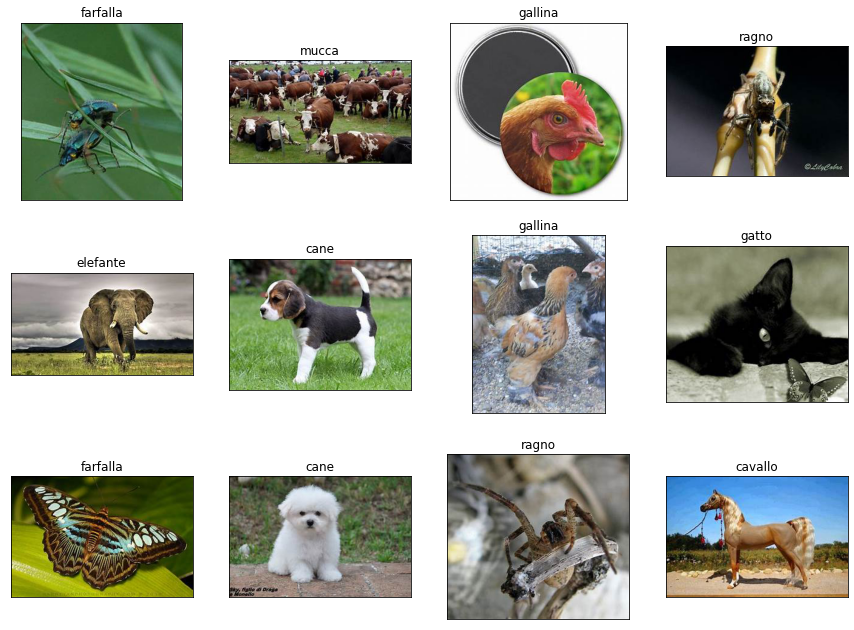

In [17]:
images = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for i in range(12):
    img_name = images.loc[i, 'Filename']
    label_str = (images.loc[i, 'ClassId'])
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(train_path,label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])
    plt.yticks([])

Una vez terminado con la visualización del conjunto de entrenamiento podemos concluir con lo siguiente:
* Nos encontramos ante un problema desbalanceado por lo que tendremos que tener en cuenta otras métricas de evaluación. 
* Además, encontramos que para determinadas clases existen pocos datos como para conseguir un modelo preciso, es por eso que podríamos realizar un Data Augmentation para obtener una mayor muestra del conjunto de datos.

# 3. Preprocesamiento de los datos<a name="preprocesamiento"></a>
En cuanto al preprocesamiento de los datos realizaremos un Data Augmentation utilizando la herramienta que nos ofrece ya Keras, utilizando `ImageDataGenerator`. El objetivo de realizar este preprocesamiento es conseguir que nuestra posterior red neuronal sea muy robusta y generalice muy bien consiguiendo así destacar las partes importantes de cada clase. A continuación, mostraremos un ejemplo de lo que vamos a realizar.

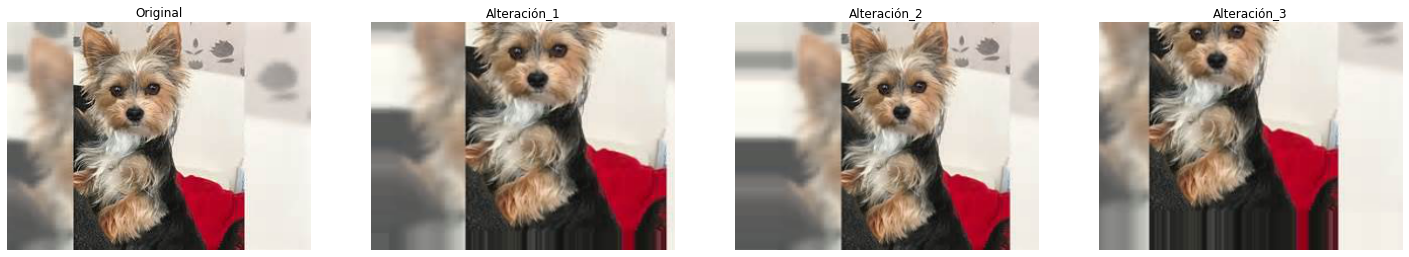

In [18]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15)

img = load_img('/kaggle/input/animals10/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# iterator
aug_iter = datagen.flow(x, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25,25))

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original')

for i in range(1,4):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')

    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title(f'Alteración_{i}')

Cómo podemos observar en las imágenes de muestra el Data Augmentation se ve puede realizar de varias formas, bien desplazando la imágen horizontal o verticalmente, bien realizar zoom a la imágen, o bien realizar una rotación de la imágen respecto de un eje distorsionandola un poco.

In [19]:
batch_size = 32
w = 224
h = 224

train_datagen = ImageDataGenerator(zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15)

test_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(w, h),
                                                    batch_size=batch_size,
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(w,h),
                                                  batch_size=batch_size,
                                                  shuffle=False)

val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size=(w,h),
                                                batch_size=batch_size,
                                                shuffle=False)

Found 20938 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.


Para realizar dichas alteraciones tendremos que establecer los siguiente valores para ImageDataGenerator:
   * **zoom_range**: en este caso se utiliza para realizar zoom a imágenes de forma aleatoria, hemos establecido que el zoom tenga un rango del 0'15.
   
   * **width_shift_range**: rango en el cual se desplazará la imagen, en este caso será un 20% de la imagen lo máximo que podrá desplazarse horizontalmente.
   
   * **height_shift_range**: en este caso es igual que en width_shift_range, pero verticalmente.
   
   * **shear_range**: se utiliza para distorsionar una imagen respecto a un eje, el objetivo es dotar a la red de otra perspectiva de la imagen para que aprenda mejor. En este caso hemos establecido un rango del 15% en cuánto a dicha rotación respecto de un eje.
  
Podemos observar los índices asociados a las correspondientes clases.

In [20]:
train_generator.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

# 4. Diseño del modelo<a name="creacion"></a>
Una vez hemos realizado el preprocesamiento a nuestro conjunto de entrenamiento, es decir el Data Augmentation, es momento de diseñar los modelos a implementar. Nos encontramos ante dos posibilidades, bien diseñar una red convolucional de forma manual, o bien importar una red preentrenada mediante Transfer Learning. Dada estás posibilidades realizaremos lo siguiente: crearemos dos redes convolucionales de forma manual y las compararemos con tres redes preentrenadas, una vez comparadas seleccionaremos los mejores modelos.
## 4.1 Creación de Redes Convolucionales
En este apartado llevaremos a cabo la creación de dos redes convolucionales de manera manual, es decir, las crearemos nosotros mismos. Encontramos dos tipos de redes a crear: redes convolucionales con grandes filtros o redes convolucionales con filtros pequeños.
### 4.1.1 Red Convolucional con grandes filtros
La primera idea que llevaremos a cabo es la de implementar una red convolucional con filtros grandes, es decir con un tamaño de kernel elevado cómo puede ser 11. Lo que intentamos conseguir con esto es comprobar si tiene un efecto positivo en la red convolucional a la hora de clasificar. La representación visual de lo que sería aplicar grandes filtros se puede ver en la siguiente imagen.

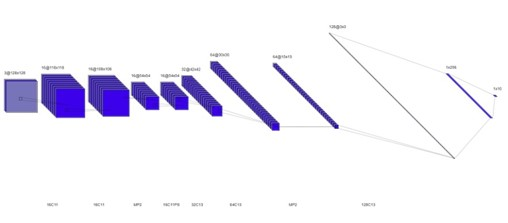

In [21]:
from IPython.display import Image

Image('../input/modelosvarp/conv_grandes_filtros.jpg')

Observamos cómo se minimiza la imagen de una forma más rápida, quizás teniendo en cuenta eso consiga forzar a la red a encontrar patrones rápidamente consiguiendo diferenciar las clases. Una vez explicado esto, vamos a realizar el diseño de dicha red convolucional, para ello lo primero es importar todas las capas de tensorflow necesarias para realizar la implementación.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout

Hemos importado las siguientes capas:
* Capa **Dense** para calcular el resultado en las capas ocultas y proporcionar una salida.

* Capa **Conv2D** encargada de aplicar la convolución a las imágenes.

* Capa **BatchNormalization** para aplicar una normalización cada vez que se aplica la convolución.

* Capa **MaxPooling2D** que va reduciendo la imagen.

* Capa **Flatten** para juntar la imagen en un único array.

* Capa **Dropout** para forzar a la red a generalizar mejor.

Además, de dichas capas también hemos importado dos callbacks:
* **EarlyStopping**: encargado reducir la varianza si el modelo no mejora en la pérdida sobre el conjunto de validación.

* **ModelCheckpoint**: encargado de conservar el modelo que ofrecio el mejor resultado en el conjunto de validación.

In [23]:
input_shape = (224,224,3)
activation = "relu"

model_cnn = keras.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = 11, strides=1, activation=activation, input_shape=input_shape),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters = 16, kernel_size = 11, strides=1, activation=activation),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(filters = 16, kernel_size = 11, strides=1, padding="same", activation=activation),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters = 32, kernel_size = 13, strides=1, activation=activation),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters = 64, kernel_size = 13, strides=1, activation=activation),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(filters = 128, kernel_size = 13, strides=1, activation=activation),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=activation),
    keras.layers.Dropout(0.4),
    Dense(10, activation = "softmax")
])

model_cnn.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "AUC")
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 214, 214, 16)      5824      
_________________________________________________________________
batch_normalization (BatchNo (None, 214, 214, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 204, 204, 16)      30992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 204, 204, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 102, 102, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 102, 102, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 102, 102, 16)      3

2023-01-11 16:05:51.043819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 16:05:51.044259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 16:05:51.045140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 16:05:51.045780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Cómo podemos observar hemos establecido las siguientes medidas para los apartados de pérdida, optimizador y métrica:
* **Categorical Crossentropy**: calcula la pérdida con la entropía cruzada.

* **Adam**: una combinación lineal entre el gradiente y el incremento anterior, y considera los gradientes recientemente aparecidos en las actualizaciones para mantener diferentes tasas de aprendizaje por variable.

* **AUC**: métrica que evalua la tasa de verdaderos positivos con la tasa de falsos positivos, métrica que utilizaremos dado que se usa en conjuntos de datos desbalanceados al tener en cuenta los falsos positivos.

A continuación, crearemos una lista con los callbacks que utilizaremos a lo largo de las implementaciones de los distintos modelos.

In [24]:
cbs = [
    ModelCheckpoint(filepath = "modelo.h5",
                   monitor = "val_loss",
                   save_best_only = True,
                   save_weights_only=True),
    EarlyStopping(monitor='val_loss',
                    min_delta=0.0002,
                    patience=5)
]

Una vez tenemos todo listo procedemos al entrenamiento de nuestro modelo, ejecutaremos 100 epochs dado que el EarlyStopping parará antes el entrenamiento.

In [25]:
history_cnn = model_cnn.fit(train_generator,validation_data=val_generator,epochs=100,verbose=1, callbacks=cbs)

2023-01-11 16:05:55.683490: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-11 16:05:57.955805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


655/655 [==============================] - 286s 420ms/step - loss: 19.9186 - auc: 0.5640 - val_loss: 4.3230 - val_auc: 0.6058
Epoch 2/100
655/655 [==============================] - 275s 420ms/step - loss: 2.2178 - auc: 0.6351 - val_loss: 3.3841 - val_auc: 0.6478
Epoch 3/100
655/655 [==============================] - 278s 424ms/step - loss: 2.1914 - auc: 0.6424 - val_loss: 3.2959 - val_auc: 0.6385
Epoch 4/100
655/655 [==============================] - 281s 429ms/step - loss: 2.2171 - auc: 0.6375 - val_loss: 3.0489 - val_auc: 0.6445
Epoch 5/100
655/655 [==============================] - 278s 423ms/step - loss: 2.1961 - auc: 0.6396 - val_loss: 2.9499 - val_auc: 0.6470
Epoch 6/100
655/655 [==============================] - 283s 432ms/step - loss: 2.2018 - auc: 0.6376 - val_loss: 3.0580 - val_auc: 0.6524
Epoch 7/100
655/655 [==============================] - 285s 435ms/step - loss: 2.1869 - auc: 0.6404 - val_loss: 2.6172 - val_auc: 0.6450
Epoch 8/100
655/655 [==============================]

Cómo podemos observar nuestro modelo a terminado antes el entrenamiento dado que no ha conseguido una mejora de pérdida en el conjunto de validación. Si observamos el resultado obtenido sobre el conjunto de validación nos encontramos que el mejor resultado es `0.6324`, un resultado bastante bajo y que nos indica de que nuestro modelo no es bueno para el problema.

Text(0, 0.5, 'AUC')

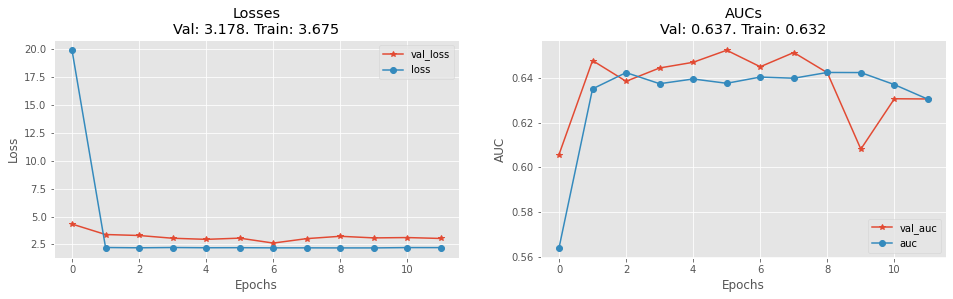

In [26]:
val_acc = np.mean(history_cnn.history['val_auc'])
val_loss = np.mean(history_cnn.history['val_loss'])
acc = np.mean(history_cnn.history['auc'])
loss = np.mean(history_cnn.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['val_loss'], marker='*')
plt.plot(history_cnn.history['loss'], marker = 'o')
plt.legend(["val_loss", "loss"])
plt.title(f"Losses\nVal: {val_loss:.3f}. Train: {loss:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history_cnn.history['val_auc'], marker='*')
plt.plot(history_cnn.history['auc'], marker='o')
plt.legend(["val_auc", "auc"])
plt.title(f"AUCs\nVal: {val_acc:.3f}. Train: {acc:.3f}")
plt.xlabel("Epochs")
plt.ylabel("AUC")

Podemos observar cómo al principio del entrenamiento encontramos cómo hay mucho sesgo y mucha varianza con el conjunto de validación. Conforme avanza el entrenamiento converge hacia un mismo punto eliminando la varianza, pero manteniendo un mínimo de sesgo.
### 4.1.2 Red Convolucional con filtros pequeños
La segunda idea que llevaremos a cabo es la de implementar una red convolucional con filtros pequeños, es decir con un tamaño de kernel reducido cómo puede ser 3. Lo que intentamos conseguir con esto es comprobar si tiene un efecto positivo en la red convolucional a la hora de clasificar. La representación visual de lo que sería aplicar filtros pequeños se puede ver en la siguiente imagen.

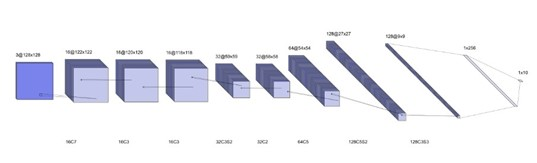

In [27]:
Image('../input/modelosvarp/conv_pequenos_filtros.jpg')

Cómo podemos apreciar en la imagen el concepto que hay detrás de utilizar filtros pequeños es el de alterar la imagen de una forma más pausada a cómo se realizaría en el modelo anterior. En este caso no utilizaremos las capas de MaxPooling2D para ver si afecta positivamente la reducción de difuminación ocasianda por esta capa. El objetivo de este modelo es obtener un mejor resultado que en el que utilizamos filtros grandes.

In [28]:
input_shape = (224,224,3)
activation = "relu"

model_cnn_small = keras.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = 7, strides=1, activation=activation, input_shape=input_shape),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters = 16, kernel_size = 3, strides=1, activation=activation),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters = 16, kernel_size = 3, strides=1, padding="same", activation=activation),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters = 32, kernel_size = 3, strides=1, activation=activation),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters = 32, kernel_size = 3, strides=1, activation=activation),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters = 64, kernel_size = 5, strides=1, activation=activation),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters = 128, kernel_size = 5, strides=3, activation=activation),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters = 128, kernel_size = 3, strides=3, activation=activation),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=activation),
    keras.layers.Dropout(0.4),
    Dense(10, activation = "softmax")
])

model_cnn_small.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "AUC")
model_cnn_small.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 218, 218, 16)      2368      
_________________________________________________________________
batch_normalization_6 (Batch (None, 218, 218, 16)      64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 216, 216, 16)      2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 216, 216, 16)      64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 216, 216, 16)      2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 216, 216, 16)      64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 214, 214, 32)     

En cuanto a la métrica de pérdida, optimización y evaluación se utilizarán las mismas que en el modelo anterior. En cuanto a los parámetros del entrenamiento se utilizarán también los mismos.

In [29]:
history_cnn_small = model_cnn_small.fit(train_generator,validation_data=val_generator,epochs=100,verbose=1, callbacks=cbs)

Epoch 1/100
655/655 [==============================] - 301s 454ms/step - loss: 3.4088 - auc: 0.6063 - val_loss: 2.2110 - val_auc: 0.6815
Epoch 2/100
655/655 [==============================] - 300s 458ms/step - loss: 2.1518 - auc: 0.6740 - val_loss: 2.5128 - val_auc: 0.6970
Epoch 3/100
655/655 [==============================] - 297s 454ms/step - loss: 2.0831 - auc: 0.7056 - val_loss: 1.9901 - val_auc: 0.7691
Epoch 4/100
655/655 [==============================] - 300s 458ms/step - loss: 1.9894 - auc: 0.7427 - val_loss: 2.1194 - val_auc: 0.7402
Epoch 5/100
655/655 [==============================] - 294s 449ms/step - loss: 1.9308 - auc: 0.7616 - val_loss: 1.8476 - val_auc: 0.7924
Epoch 6/100
655/655 [==============================] - 295s 450ms/step - loss: 1.8949 - auc: 0.7721 - val_loss: 1.9656 - val_auc: 0.7638
Epoch 7/100
655/655 [==============================] - 295s 450ms/step - loss: 1.8704 - auc: 0.7804 - val_loss: 2.5253 - val_auc: 0.7167
Epoch 8/100
655/655 [====================

Podemos observar como el entrenamiento de este modelo ha durado mucho más que el modelo con filtros grandes, además, ha obtenido un mejor resultado en el conjunto de validación cómo es `0.9`. A continuación, visualizaremos de una forma gráfica cómo ha ido evolucionando dicho entrenamiento.

Text(0, 0.5, 'AUC')

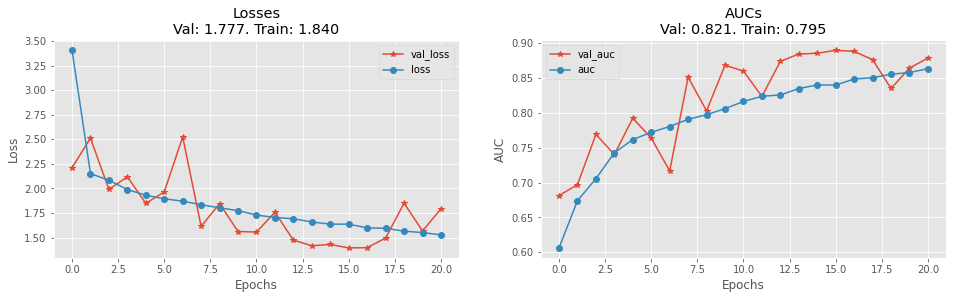

In [30]:
val_acc = np.mean(history_cnn_small.history['val_auc'])
val_loss = np.mean(history_cnn_small.history['val_loss'])
acc = np.mean(history_cnn_small.history['auc'])
loss = np.mean(history_cnn_small.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history_cnn_small.history['val_loss'], marker='*')
plt.plot(history_cnn_small.history['loss'], marker = 'o')
plt.legend(["val_loss", "loss"])
plt.title(f"Losses\nVal: {val_loss:.3f}. Train: {loss:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history_cnn_small.history['val_auc'], marker='*')
plt.plot(history_cnn_small.history['auc'], marker='o')
plt.legend(["val_auc", "auc"])
plt.title(f"AUCs\nVal: {val_acc:.3f}. Train: {acc:.3f}")
plt.xlabel("Epochs")
plt.ylabel("AUC")

Podemos observar cómo existe una pequeña varianza entre el conjunto de entrenamiento y validación, mientra que el conjunto de entrenamiento tiene una mejora graudal el conjunto de validación tiene picos que alterán la mejora. En cuanto a la evolución del sesgo en ambos conjuntos conforme evolucionan las épocas mejora, salvo en el conjunto de validación al final del entrenamiento. En conclusión, obtenemos un buen resultado en el conjunto de validación, pero creemos qu esta muy lejos de ser una solución prometedora. Por lo tanto, tendremos que buscar otros diseños con el objetivo de encontrar el modelo que nos ofrezca un resultado óptimo.
## 4.2 Diseño de Redes de Transfer learning
La segunda opción que hemos comentado anteriormente es la de importar redes ya preentrenadas de Transfer Learning. La ventaja de este tipo de redes es que vienen prepraradas para ajustar los pesos que ya tienen entrenados y ofrecer una clasificación, no te tienes que preocupar por realizar un diseño específico.
### 4.2.1 Red Neuronal: ResNet50
La primera red preentrenada que probaremos es la red **ResNet50**, es una red residual lo que quiere decir que tiene capas enlazadas con otras capas no necesariamente contiguas. Empezaremos importando dicha red desde tensorflow.

In [31]:
from tensorflow.keras.applications import ResNet50

model_resnet50 = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

94781440/94765736 [==============================] - 1s 0us/step


Una vez tenemos cargado nuestro modelo ResNet50 lo que haremos será congelar el entrenamiento de las capas para mantener los pesos originales.

In [32]:
for layers in model_resnet50.layers:
    layers.trainable = False

Lo que haremos con la salida de dicho modelo será enlazarlo con una capa oculta de tipo Dense, que a su vez estará conectada con la última capa Dense encargada de ofrecer la salida y la clasificación. Entre estás dos capas encontramos una capa Dropout para forzar a nuestra red a generalizar mejor en las últimas capas, forzando así a reconocer patrones diferenciales.

In [33]:
from keras.layers import  Dropout
y = Flatten()(model_resnet50.output)
y = Dropout(0.5)(y)
y = Dense(10, activation = "softmax")(y)

model_resnet50 = keras.Model(model_resnet50.input, y)
model_resnet50.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "AUC")
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Una vez tenemos el modelo compilado procedemos a entrenarlo durante 100 epochs dado que tenemos EarlyStopping, lo que hara que se detenga antes de llegar a las 100 epochs.

In [34]:
history_resnet50 = model_resnet50.fit(train_generator, validation_data=val_generator, epochs=100, verbose=1, callbacks=cbs)

Epoch 1/100
655/655 [==============================] - 280s 423ms/step - loss: 4.8333 - auc: 0.9184 - val_loss: 3.4369 - val_auc: 0.9528
Epoch 2/100
655/655 [==============================] - 277s 422ms/step - loss: 5.0587 - auc: 0.9399 - val_loss: 4.1397 - val_auc: 0.9593
Epoch 3/100
655/655 [==============================] - 276s 421ms/step - loss: 5.0243 - auc: 0.9471 - val_loss: 4.7457 - val_auc: 0.9589
Epoch 4/100
655/655 [==============================] - 277s 424ms/step - loss: 5.1185 - auc: 0.9521 - val_loss: 4.9728 - val_auc: 0.9624
Epoch 5/100
655/655 [==============================] - 276s 422ms/step - loss: 4.8672 - auc: 0.9562 - val_loss: 5.4058 - val_auc: 0.9630
Epoch 6/100
655/655 [==============================] - 275s 420ms/step - loss: 4.7443 - auc: 0.9579 - val_loss: 6.0654 - val_auc: 0.9601


Dicho modelo consigue un resultado en el conjunto de validación de `0.9641`, un resalto muy bueno para nuestro problema. Además, realiza el entrenamiento en pocas epochs. A continuación, veremos cómo evoluciona dicho entrenamiento de una forma más gráfica.

Text(0, 0.5, 'AUC')

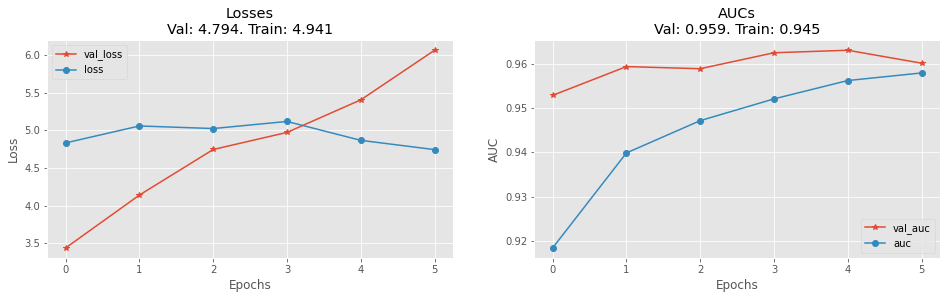

In [35]:
val_acc = np.mean(history_resnet50.history['val_auc'])
val_loss = np.mean(history_resnet50.history['val_loss'])
acc = np.mean(history_resnet50.history['auc'])
loss = np.mean(history_resnet50.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history_resnet50.history['val_loss'], marker='*')
plt.plot(history_resnet50.history['loss'], marker = 'o')
plt.legend(["val_loss", "loss"])
plt.title(f"Losses\nVal: {val_loss:.3f}. Train: {loss:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history_resnet50.history['val_auc'], marker='*')
plt.plot(history_resnet50.history['auc'], marker='o')
plt.legend(["val_auc", "auc"])
plt.title(f"AUCs\nVal: {val_acc:.3f}. Train: {acc:.3f}")
plt.xlabel("Epochs")
plt.ylabel("AUC")

Como podemos observar en las gráficas nuestro modelo tiene un mínimo de varianza dado que existe una pequeña diferencia entre el conjunto de entrenamiento y de validación. Además, encontramos que nuestro modelo tiene un poco de sesgo dado que el error obtenido tanto en entrenamiento como en validación es algo elevado al óptimo.

In [36]:
model_resnet50.save("model_resnet50.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Por último, dado que nuestro modelo consigue un buen resultado sobre el conjunto de validación decidimos guardarnos el modelo.
### 4.2.2 Red Neuronal: EfficientNetB7
La segunda red preentrenada que utilizaremos es la EfficientNetB7, al igual que sucedia con la ResNet50 importaremos la red y mantendremos los pesos originales. Por lo tanto, lo primero que tenemos que hacer es cargarla.

In [37]:
from tensorflow.keras.applications import EfficientNetB7

model_efficientnetb7 = EfficientNetB7(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

258088960/258076736 [==============================] - 1s 0us/step


Una vez cargada la red EfficientNetB7 lo que haremos será congelar las capas intermedias para que no modifiquen sus pesos.

In [38]:
for layers in model_efficientnetb7.layers:
    layers.trainable = False

Después de congelar dichas capas crearemos la salida de nuestra red. Para ello tendremos una primera capa oculta de tipo Dense conectada con una última capa Dense encargada de generar la salida y la clasificación. Además, entre medias de las dos capas encontramos una capa Dropout obligando a la red a ser más robusta y generalizar mejor.

In [39]:
from keras.layers import  Dropout
y = Flatten()(model_efficientnetb7.output)
y = Dropout(0.5)(y)
y = Dense(10, activation = "softmax")(y)

model_efficientnetb7 = keras.Model(model_efficientnetb7.input, y)
model_efficientnetb7.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "AUC")
model_efficientnetb7.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

Una vez tenemos el modelo diseñado procedemos a realizar el entrenamiento de la misma forma que lo llevamos haciendo a lo largo del proyecto, entrenaremos durante 100 epochs esperando que el EarlyStopping paralice el entrenamiento antes.

In [40]:
history_efficientnetb7 = model_efficientnetb7.fit_generator(train_generator,validation_data=val_generator,epochs=100,verbose=1, callbacks=cbs)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
655/655 [==============================] - 377s 549ms/step - loss: 1.3871 - auc: 0.9667 - val_loss: 1.1296 - val_auc: 0.9807
Epoch 2/100
655/655 [==============================] - 342s 522ms/step - loss: 1.3066 - auc: 0.9750 - val_loss: 1.5293 - val_auc: 0.9777
Epoch 3/100
655/655 [==============================] - 341s 520ms/step - loss: 1.2885 - auc: 0.9777 - val_loss: 1.4032 - val_auc: 0.9818
Epoch 4/100
655/655 [==============================] - 348s 530ms/step - loss: 1.2191 - auc: 0.9799 - val_loss: 1.9259 - val_auc: 0.9767
Epoch 5/100
655/655 [==============================] - 359s 547ms/step - loss: 1.2676 - auc: 0.9812 - val_loss: 1.6012 - val_auc: 0.9807
Epoch 6/100
655/655 [==============================] - 349s 533ms/step - loss: 1.2055 - auc: 0.9821 - val_loss: 1.6671 - val_auc: 0.9835


Una vez realizado el entrenamiento podemos observar cómo el mejor resultado obtenido sobre el conjunto de validación es de `0.9824`, lo que es sin duda un muy buen resultado siendo el mejor resultado hasta el momento. Por lo tanto, lo que realizaremos a continuación será guardarnos dicho modelo.

In [41]:
model_efficientnetb7.save("model_efficientnetb7.h5")

Dado que ya tenemos guardado nuestro modelo lo siguiente que haremos será mostrar gráficamente cómo se ha evolucionado el entrenamiento.

Text(0, 0.5, 'AUC')

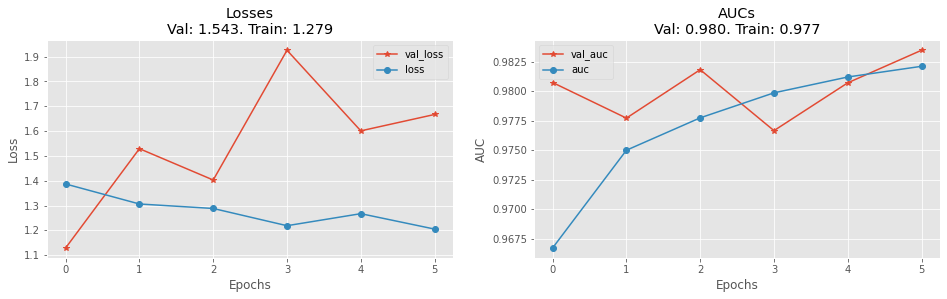

In [42]:
val_acc = np.mean(history_efficientnetb7.history['val_auc'])
val_loss = np.mean(history_efficientnetb7.history['val_loss'])
acc = np.mean(history_efficientnetb7.history['auc'])
loss = np.mean(history_efficientnetb7.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history_efficientnetb7.history['val_loss'], marker='*')
plt.plot(history_efficientnetb7.history['loss'], marker = 'o')
plt.legend(["val_loss", "loss"])
plt.title(f"Losses\nVal: {val_loss:.3f}. Train: {loss:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history_efficientnetb7.history['val_auc'], marker='*')
plt.plot(history_efficientnetb7.history['auc'], marker='o')
plt.legend(["val_auc", "auc"])
plt.title(f"AUCs\nVal: {val_acc:.3f}. Train: {acc:.3f}")
plt.xlabel("Epochs")
plt.ylabel("AUC")

Podemos observar en la gráfica de pérdida cómo existe un mínimo de varianza al existir una pequeña diferencia entre el conjunto de entrenamiento y validación. En cuanto al sesgo vemos cómo en este modelo es mucho más reducido que en el modelo anterior acercandose mucho más al resultado óptimo. En conclusión este modelo parece mejor sobre el conjunto de validación que el modelo de ResNet50.
### 4.2.3 Red Neuronal: EfficientNetB5
La última red preentrenada que probaremos es la EfficientNetB5, el motivo de seleccionar otra red del grupo EfficientNet se debe al muy buen resultado obtenido con su hermana la EfficientNetB7. Por lo tanto, lo primero que haremos será cargar dicha red preentrenada.

In [43]:
from tensorflow.keras.applications import EfficientNetB5

model_efficientnetb5 = EfficientNetB5(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

115277824/115263384 [==============================] - 1s 0us/step


Una vez tenemos cargada la red seguiremos el mismo proceso que en las otras redes, congelaremos las capas intermedias para que mantengan los pesos originales.

In [44]:
for layers in model_efficientnetb5.layers:
    layers.trainable = False

A continuación, se realizará el mismo procedimiento para conseguir la salida y por tanto la clasificación. Tendremos una capa oculta Dense conectada con la salida de nuestro modelo, seguida de esta capa Dense encontraremos la última capa encargada de ofrecer la clasificación. Al igual que en el resto de modelos encontramos que existe una capa Dropout entre las dos últimas capas Dense para forzar a nuestro modelo generalizar y no sobreajustar.

In [45]:
y = Flatten()(model_efficientnetb5.output)
y = Dropout(0.5)(y)
y = Dense(10, activation = "softmax")(y)

model_efficientnetb5 = keras.Model(model_efficientnetb5.input, y)
model_efficientnetb5.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "AUC")
model_efficientnetb5.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

Lo siguente que se realizará es el entrenamiento de nuestro modelo, que será de la misma forma que el resto, se entrenará durante 100 epochs hasta que el EarlyStopping lo detenga.

In [46]:
history_efficientnetb5 = model_efficientnetb5.fit_generator(train_generator,validation_data=val_generator,epochs=100,verbose=1, callbacks=cbs)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
655/655 [==============================] - 325s 479ms/step - loss: 1.3173 - auc: 0.9649 - val_loss: 1.1427 - val_auc: 0.9769
Epoch 2/100
655/655 [==============================] - 307s 469ms/step - loss: 1.2301 - auc: 0.9749 - val_loss: 1.2966 - val_auc: 0.9797
Epoch 3/100
655/655 [==============================] - 307s 469ms/step - loss: 1.2218 - auc: 0.9774 - val_loss: 1.4505 - val_auc: 0.9784
Epoch 4/100
655/655 [==============================] - 309s 471ms/step - loss: 1.1726 - auc: 0.9790 - val_loss: 1.6228 - val_auc: 0.9796
Epoch 5/100
655/655 [==============================] - 301s 459ms/step - loss: 1.0525 - auc: 0.9819 - val_loss: 1.6573 - val_auc: 0.9811
Epoch 6/100
655/655 [==============================] - 315s 481ms/step - loss: 1.2351 - auc: 0.9798 - val_loss: 1.7942 - val_auc: 0.9815


El mejor resultado obtenido durante nuestro entrenamiento sobre el conjunto de validación es de `0.9827`, un resultado muy bueno otra vez. Por lo tanto, nos guardaremos dicho modelo para una posterior evaluación.

In [47]:
model_efficientnetb5.save("model_efficientnetb5.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Una vez guardado dicho modelo procedemos a mostrar gráficamente cómo ha evolucionado el entrenamiento de nuestro modelol.

Text(0, 0.5, 'AUC')

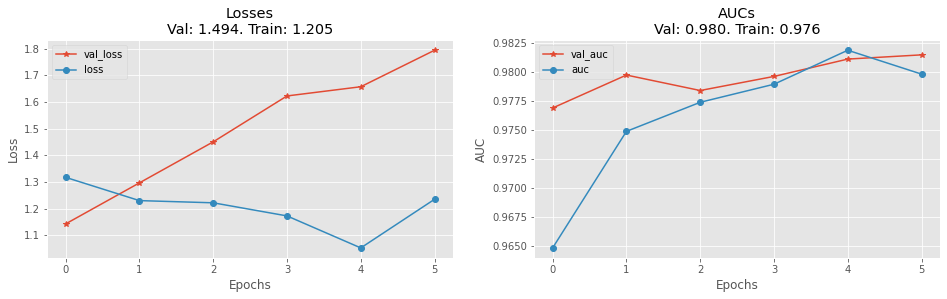

In [48]:
val_acc = np.mean(history_efficientnetb5.history['val_auc'])
val_loss = np.mean(history_efficientnetb5.history['val_loss'])
acc = np.mean(history_efficientnetb5.history['auc'])
loss = np.mean(history_efficientnetb5.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history_efficientnetb5.history['val_loss'], marker='*')
plt.plot(history_efficientnetb5.history['loss'], marker = 'o')
plt.legend(["val_loss", "loss"])
plt.title(f"Losses\nVal: {val_loss:.3f}. Train: {loss:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history_efficientnetb5.history['val_auc'], marker='*')
plt.plot(history_efficientnetb5.history['auc'], marker='o')
plt.legend(["val_auc", "auc"])
plt.title(f"AUCs\nVal: {val_acc:.3f}. Train: {acc:.3f}")
plt.xlabel("Epochs")
plt.ylabel("AUC")

Podemos observar cómo sigue existiendo un mínimo de varianza entre el resultado obtenido en entrenamiento y validación. Además, podemos observar en la pérdida cómo el sesgo va aumentando en el conjunto de validación. Aún teniendo en cuenta todo lo comentado el modelo obtenido es muy bueno.
# 5. Análisis de los resultados obtenidos<a name="resultados"></a>
En este apartado evaluaremos frente al test los tres mejores modelos obtenidos, en este caso los tenemos ya entrenados y almacenados en la carpeta _**modelosvarp**_ que hemos creado para este proyecto. Por lo tanto, lo primero que realizamos es cargar los modelos con `load_model` de tensorflow para modelos ya entrenados.

In [49]:
model_resnet50 = tf.keras.models.load_model('../input/modelosvarp/model_resnet50.h5')
model_efficientnetb7 = tf.keras.models.load_model('../input/modelosvarp/model_efficientnetb7.h5')
model_efficientnetb5 = tf.keras.models.load_model('../input/modelosvarp/model_efficientnetb5.h5')

Una vez tenemos cargados los distintos modelos entrenados procedemos a evaluarlos frente al test.

In [50]:
test_loss_resnet50, test_auc_resnet50 = model_resnet50.evaluate(test_generator, verbose=1)
test_loss_efficientnetb7, test_auc_efficientnetb7 = model_efficientnetb7.evaluate(test_generator, verbose=1)
test_loss_efficientnetb5, test_auc_efficientnetb5 = model_efficientnetb5.evaluate(test_generator, verbose=1)

83/83 [==============================] - 16s 143ms/step - loss: 1.9561 - auc: 0.9757


Si observamos los resultados el mejor modelo que obtenemos en cuanto a AUC es el modelo EfficientNetB7, en cuanto a pérdida es el modelo EfficientNetB5. Podemos observar cómo los modelos de EfficientNet son muy buenos para este tipo de problemas siendo muy sencillos de utilizar. Por lo tanto, tendríamos el siguiente orden de resultados prente al test según AUC:

1. Modelo **EfficientNetB7**

2. Modelo **EfficientNetB5**

3. Modelo **ResNet50**

Y en cuanto a pérdida:

1. Modelo **EfficientNetB5**

2. Modelo **EfficientNetB7**

3. Modelo **ResNet50**

Con motivo de mejorar dichos resultados frente al test lo que realizaremos a continuación es construir un ensemble muy simple para comprobar si obtenemos una pequeñe mejora a la hora de la clasificación.
# 6. Detalles del modelo final: Ensemble<a name="validacion"></a>
Por lo tanto, cómo se ha comentado la idea final que hemos planteado es la de crear un ensemble muy sencillo para comprobar si existe una mejora. Para elaborar dicho ensemble la idea que hay detrás es la que se puede apreciar en la siguiente imagen:

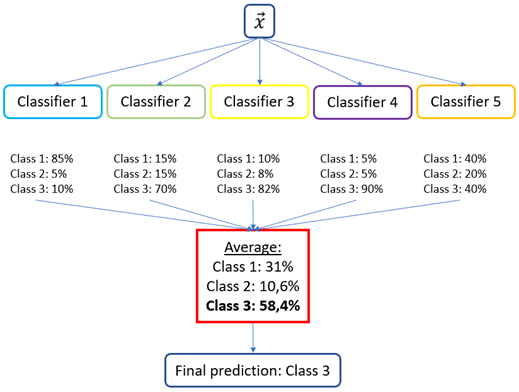

In [51]:
Image('../input/modelosvarp/ensemble.png')

Cómo podemos observar no se trata de un ensemble de voto por la mayoría, nuestro ensemble tendrá en cuenta las diferentes probabilidades de clasificación que ofrece cada modelo por separado. Se podría decir que nuestro ensemble realiza una agregación de resultados por la media de probabilidades obtenidas. Conseguir esto es muy sencillo de hacer, lo único que tendremos que realizar es la predicción cada modelo por separado y sumar las probabilidades, aunque no realizemos la media al aplicar `np.argmax()` estaremos clasificando a la clase que tenga una mayor suma de probabilidades obteniendo el mismo resultado.

In [52]:
prob_a = model_resnet50.predict(test_generator)
prob_b = model_efficientnetb7.predict(test_generator)
prob_c = model_efficientnetb5.predict(test_generator)

probabilities = np.add(prob_a, prob_b)
probabilities = np.add(probabilities, prob_c)

Por lo tanto, una vez tenemos agrupadas las probabilidades de todos los modelos calculamos como se clasificaría almacenandolo en prediction.

In [53]:
prediction = np.argmax(probabilities,axis=1)

A continuación, guardaremos el resultado verdadero como true_prediction.

In [54]:
true_prediction = test_generator.classes

Con el objetivo de compara el resultado de nuestro ensemble con el de los modelos por serparado con la misma métrica de evaluación (AUC) tendremos que realizar una serie de paso para poder evaluarlo. Para ello tendremos que realizar un OneHotEncoder sobre nuestros arrays prediction y true_prediction.

In [55]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()

In [56]:
true_prediction_df = true_prediction.reshape(-1,1)
prediction_df = prediction.reshape(-1,1)
true_prediction_df = pd.DataFrame(true_prediction_df)
prediction_df = pd.DataFrame(prediction_df)

prediction_transformed = onehotencoder.fit_transform(prediction_df).toarray()
true_prediction_transformed = onehotencoder.fit_transform(true_prediction_df).toarray()

Una vez tenemos preparado nuestra predicción para poder ser evaluado con la métrica AUC procedemos a hacerlo.

In [57]:
from sklearn.metrics import roc_auc_score

roc_auc_score(true_prediction_transformed, prediction_transformed, multi_class='ovr')

0.9801319581932596

Obtenemos un resultado frente al test de `0.98013`, un resultado muy bueno dado el problema que teniamos sobre una muesra desbalanceada. Además, podemos concluir con que la agregación de resultados de una forma muy sencilla nos ofrece un mejor resultado que por separado. A continuación seguiremos haciendo comparaciones con diferentes métricas de evaluación.

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Realizaremos un classification_report para cada modelo por separado y en última instancia lo realizaremos del ensemble.

In [59]:
print(classification_report(true_prediction, np.argmax(prob_a,axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9315    0.9220    0.9267       487
           1     0.9234    0.9163    0.9198       263
           2     0.9257    0.9384    0.9320       146
           3     0.9186    0.9575    0.9376       212
           4     0.9675    0.9582    0.9628       311
           5     0.8235    0.9167    0.8676       168
           6     0.8490    0.8670    0.8579       188
           7     0.9200    0.8846    0.9020       182
           8     0.9914    0.9524    0.9715       483
           9     0.9471    0.9572    0.9521       187

    accuracy                         0.9307      2627
   macro avg     0.9198    0.9270    0.9230      2627
weighted avg     0.9321    0.9307    0.9311      2627



In [60]:
print(classification_report(true_prediction, np.argmax(prob_b,axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9582    0.9425    0.9503       487
           1     0.8811    0.9582    0.9180       263
           2     0.9728    0.9795    0.9761       146
           3     0.9581    0.9717    0.9649       212
           4     0.9770    0.9582    0.9675       311
           5     0.9643    0.9643    0.9643       168
           6     0.9551    0.9043    0.9290       188
           7     0.9486    0.9121    0.9300       182
           8     0.9774    0.9834    0.9804       483
           9     0.9574    0.9626    0.9600       187

    accuracy                         0.9558      2627
   macro avg     0.9550    0.9537    0.9540      2627
weighted avg     0.9565    0.9558    0.9559      2627



In [61]:
print(classification_report(true_prediction, np.argmax(prob_c,axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9049    0.9774    0.9398       487
           1     0.9478    0.8973    0.9219       263
           2     0.9667    0.9932    0.9797       146
           3     0.9761    0.9623    0.9691       212
           4     0.9836    0.9614    0.9724       311
           5     1.0000    0.9048    0.9500       168
           6     0.9081    0.8936    0.9008       188
           7     0.9235    0.9286    0.9260       182
           8     0.9712    0.9772    0.9742       483
           9     0.9672    0.9465    0.9568       187

    accuracy                         0.9509      2627
   macro avg     0.9549    0.9442    0.9491      2627
weighted avg     0.9519    0.9509    0.9509      2627



Una vez realizado de los modelos por separado podemos observar que el modelo que obtiene un mejor f1-score es el modelo EfficientNetB7, siendo otra vez el mejor modelo por separado. A continuación, veremos que resultado obtiene el ensemble que hemos creado.

In [62]:
print(classification_report(true_prediction, prediction, digits=4))

              precision    recall  f1-score   support

           0     0.9406    0.9754    0.9577       487
           1     0.9474    0.9582    0.9527       263
           2     0.9864    0.9932    0.9898       146
           3     0.9765    0.9811    0.9788       212
           4     0.9805    0.9711    0.9758       311
           5     0.9758    0.9583    0.9670       168
           6     0.9293    0.9096    0.9194       188
           7     0.9714    0.9341    0.9524       182
           8     0.9958    0.9855    0.9906       483
           9     0.9785    0.9733    0.9759       187

    accuracy                         0.9676      2627
   macro avg     0.9682    0.9640    0.9660      2627
weighted avg     0.9679    0.9676    0.9677      2627



Podemos observar cómo obtiene un 0.9676 siendo otra vez el resultado superior a que si lo evaluasemos por separado. Por lo tanto, podemos concluir con que es muy interesante plantearse siempre la implementación de un ensemble aunque este sea muy sencillo, cómo es el caso. Si mostramos la matriz de confusión de dicho ensemble tendría la siguiente forma:

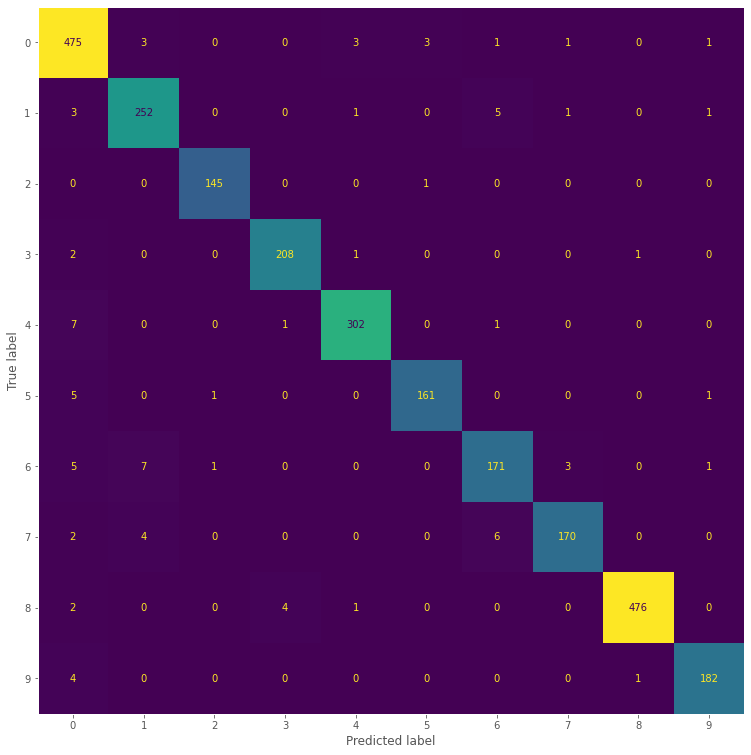

In [63]:
cm = confusion_matrix(true_prediction, prediction)


fig, ax = plt.subplots(figsize=(13,13))
ax.grid(False)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

disp.plot(ax=ax,
         colorbar = False)

Podemos apreciar cómo clasifica la mayoría de clases dónde debería, está matriz de confusión es muy clarificadora en el sentido de que nos muestra que nuestro modelo final, el ensemble, es muy buen modelo para el problema que se nos había presentado.
# 7. Conclusión<a name="conclusion"></a> 
Para terminar, destacar que la implementación de los diferentes tipos de modelos nos permite sacar unas serie de conclusiones:
* Una buena arquitectura en un diseño creado manualmente puede ser muy superior a cualquier modelo preentrenado.

* La problemática que encontramos del punto anterior es que para encontrar dicha arquitectura tienes que realizar muchas pruebas y el entrenamiento se dispara en tiempo de ejecución para encontrar la óptima.

* Los modelo preentrenados solventan muy bien dicha problemática de encontrar la mejor arquitectura, dado que ofrecen un muy buen resultado.

* La agrupación de resultados puede ofrecer un mejor resultado, esto se ve cuando realizamos una agregación muy simple con el ensemble.

En conclusión, estamos muy contentos con el trabajo realizado con este proyecto dado que hemos conseguido entender todos esos puntos y profundizar en Tensorflow/Keras. Además, creemos que el resultado obtenido es muy bueno dado el problema que teniamos al tener muy pocas muestras de ciertas clases. Por lo tanto, la valoración interna que realizamos es muy buena y creemos que la mejor forma de aprender es poniéndonos delante de un problema.